In [2]:
import os
import cv2
import pandas as pd
import numpy as np
CSV_PATH = "NeoJaundice/chd_jaundice_published_2.csv"
IMG_DIR = "NeoJaundice/images"
df = pd.read_csv(CSV_PATH)
print(df.columns)
image_data = []
labels = []
for _, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["image_idx"])
    img = cv2.imread(img_path)
    if img is not None:
        image_data.append(img)
        labels.append(row["blood(mg/dL)"])
    else:
        print(f"Warning: Image not found or unreadable - {img_path}")
image_data = np.array(image_data)
labels = np.array(labels)
print(f"Loaded {len(image_data)} images.")

Index(['patient_id', 'image_idx', 'gender', 'gestational_age', 'age(day)',
       'weight', 'blood(mg/dL)', 'Treatment'],
      dtype='object')
Loaded 2235 images.


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_mask_hsv(img, lower_hsv, upper_hsv):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_hsv, upper_hsv)
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

def extract_yellow_card_mask(img):
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    return extract_mask_hsv(img, lower_yellow, upper_yellow)

def extract_white_card_mask(img):
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 30, 255])
    return extract_mask_hsv(img, lower_white, upper_white)

def extract_black_card_mask(img):
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([180, 255, 50])
    return extract_mask_hsv(img, lower_black, upper_black)

def extract_red_card_mask(img):
    lower_red1 = np.array([0, 100, 20])
    upper_red1 = np.array([5, 255, 255])
    return extract_mask_hsv(img, lower_red1, upper_red1)


def compute_patch_means(lab_img, patch_mask):
    patch_pixels = lab_img[patch_mask > 0]
    if patch_pixels.size == 0:
        return None
    L = patch_pixels[:,0]
    A = patch_pixels[:,1]
    B = patch_pixels[:,2]
    return np.mean(L), np.mean(A), np.mean(B)

def correct_image_color_multicard(full_img, yellow_mask, white_mask, black_mask, red_mask,
                                  target_lab_yellow, target_lab_white, target_lab_black, target_lab_red):
    lab_full = cv2.cvtColor(full_img, cv2.COLOR_BGR2LAB)

    yellow_means = compute_patch_means(lab_full, yellow_mask)
    white_means = compute_patch_means(lab_full, white_mask)
    black_means = compute_patch_means(lab_full, black_mask)
    red_means = compute_patch_means(lab_full, red_mask)

    if None in (yellow_means, white_means, black_means, red_means):
        print("One or more patches not detected properly. Skipping correction.")
        return full_img

    L_y, A_y, B_y = yellow_means
    L_w, A_w, B_w = white_means
    L_b, A_b, B_b = black_means
    L_r, A_r, B_r = red_means

    delta_L = np.mean([target_lab_yellow[0] - L_y,
                       target_lab_white[0] - L_w,
                       target_lab_black[0] - L_b,
                       target_lab_red[0] - L_r])
    delta_A = np.mean([target_lab_yellow[1] - A_y,
                       target_lab_white[1] - A_w,
                       target_lab_black[1] - A_b,
                       target_lab_red[1] - A_r])
    delta_B = np.mean([target_lab_yellow[2] - B_y,
                       target_lab_white[2] - B_w,
                       target_lab_black[2] - B_b,
                       target_lab_red[2] - B_r])

    L_full, A_full, B_full = cv2.split(lab_full)
    L_full = np.clip(L_full + delta_L, 0, 255)
    A_full = np.clip(A_full + delta_A, 0, 255)
    B_full = np.clip(B_full + delta_B, 0, 255)

    corrected_lab = cv2.merge([L_full, A_full, B_full]).astype(np.uint8)
    corrected_bgr = cv2.cvtColor(corrected_lab, cv2.COLOR_LAB2BGR)

    return corrected_bgr


In [4]:
import cv2
import numpy as np
bgr = [0, 0, 0]
lab = cv2.cvtColor( np.uint8([[bgr]] ), cv2.COLOR_BGR2LAB)[0][0]
print(lab)  

[  0 128 128]


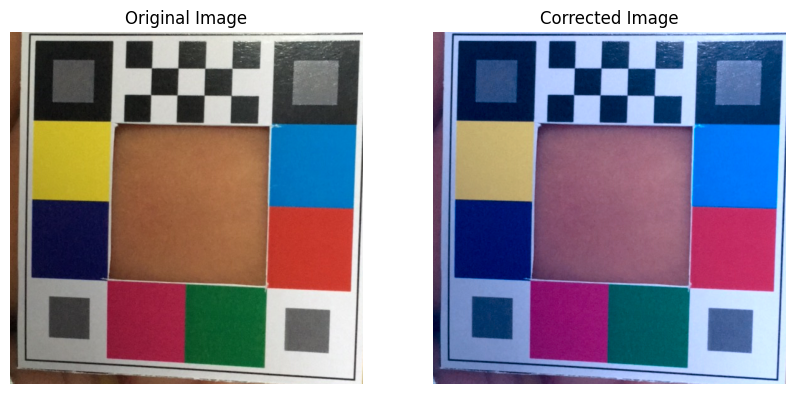

In [5]:
img = image_data[289]


target_lab_yellow = (207.0, 121.0, 209.0)
target_lab_white = (255.0, 128.0, 128.0)
target_lab_black = (0.0, 128.0, 128.0)
target_lab_red = (82.0, 207.0, 20.0)  


yellow_mask = extract_yellow_card_mask(img)
white_mask = extract_white_card_mask(img)
black_mask = extract_black_card_mask(img)
red_mask = extract_red_card_mask(img)

corrected_img = correct_image_color_multicard(
    img, yellow_mask, white_mask, black_mask, red_mask,
    target_lab_yellow, target_lab_white, target_lab_black, target_lab_red
)

# Show results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB))
plt.title("Corrected Image")
plt.axis('off')

plt.show()


In [6]:
def extract_skin_roi(image, roi_fraction=0.35):
    h, w = image.shape[:2]
    roi_h, roi_w = int(h * roi_fraction), int(w * roi_fraction)
    start_y = (h - roi_h) // 2
    start_x = (w - roi_w) // 2
    roi = image[start_y:start_y+roi_h, start_x:start_x+roi_w]
    return roi


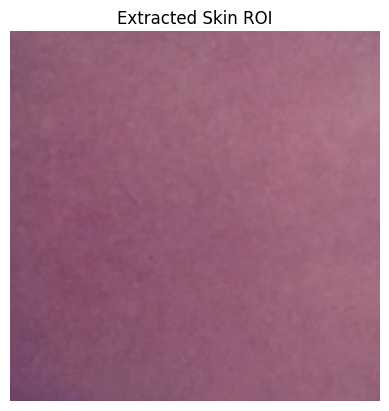

In [7]:
skin_roi = extract_skin_roi(corrected_img)

plt.imshow(cv2.cvtColor(skin_roi, cv2.COLOR_BGR2RGB))
plt.title("Extracted Skin ROI")
plt.axis("off")
plt.show()


In [8]:
import cv2
import numpy as np

def extract_color_spaces(img):
    img_resized = cv2.resize(img, (128, 128))
    rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
    ycbcr = cv2.cvtColor(img_resized, cv2.COLOR_BGR2YCrCb) 
    lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
    
    rgb_seq = rgb.reshape(-1, 3)
    hsv_seq = hsv.reshape(-1, 3)
    ycbcr_seq = ycbcr.reshape(-1, 3)
    lab_seq = lab.reshape(-1, 3)
    
    return rgb_seq, hsv_seq, ycbcr_seq, lab_seq


In [9]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    target_lab_yellow = (207.0, 121.0, 209.0)
    target_lab_white = (255.0, 128.0, 128.0)
    target_lab_black = (0.0, 128.0, 128.0)
    target_lab_red = (82.0, 207.0, 20.0)  


    yellow_mask = extract_yellow_card_mask(img)
    white_mask = extract_white_card_mask(img)
    black_mask = extract_black_card_mask(img)
    red_mask = extract_red_card_mask(img)

    corrected_img = correct_image_color_multicard(
        img, yellow_mask, white_mask, black_mask, red_mask,
        target_lab_yellow, target_lab_white, target_lab_black, target_lab_red
    )

    skin_roi = extract_skin_roi(corrected_img)
    return extract_color_spaces(skin_roi)


In [20]:

b_means = []
cb_means = []
s_means = []
labels = []

for idx, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["image_idx"])
    try:
        rgb, hsv, ycbcr, lab = preprocess_image(img_path)

        b_mean = np.mean(lab[:, 2])      
        cb_mean = np.mean(ycbcr[:, 2])  
        s_mean = np.mean(hsv[:, 1])   
        b_means.append(b_mean)
        cb_means.append(cb_mean)
        s_means.append(s_mean)
        labels.append(row["blood(mg/dL)"])
    except Exception as e:
        print(f"Skipping {img_path} due to error: {e}")
        continue

X = np.stack([b_means, cb_means , s_means], axis=1)
y = np.array(labels)

print("Feature shape:", X.shape)
print("Label shape:", y.shape)

One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
One or more patches not detected properl

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Input(shape=(3,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  
])
model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=16)


Epoch 1/100
112/112 [==============================] - 0s 1ms/step - loss: 102.7596 - mae: 6.5567 - val_loss: 22.3093 - val_mae: 3.9602
Epoch 2/100
112/112 [==============================] - 0s 901us/step - loss: 19.7939 - mae: 3.7116 - val_loss: 20.1834 - val_mae: 3.7303
Epoch 3/100
112/112 [==============================] - 0s 1ms/step - loss: 18.0932 - mae: 3.5069 - val_loss: 17.6356 - val_mae: 3.4369
Epoch 4/100
112/112 [==============================] - 0s 910us/step - loss: 17.2454 - mae: 3.3967 - val_loss: 16.8217 - val_mae: 3.3188
Epoch 5/100
112/112 [==============================] - 0s 919us/step - loss: 16.7411 - mae: 3.3183 - val_loss: 16.7264 - val_mae: 3.3144
Epoch 6/100
112/112 [==============================] - 0s 919us/step - loss: 16.9327 - mae: 3.3265 - val_loss: 16.3187 - val_mae: 3.2499
Epoch 7/100
112/112 [==============================] - 0s 928us/step - loss: 16.6349 - mae: 3.3023 - val_loss: 16.7549 - val_mae: 3.2221
Epoch 8/100
112/112 [=======================

In [26]:
loss, mae = model.evaluate(X_val, y_val)
print(f"Validation MAE: {mae:.3f}")

14/14 [==============================] - 0s 693us/step - loss: 13.8382 - mae: 2.9151
Validation MAE: 2.915


14/14 [==============================] - 0s 615us/step


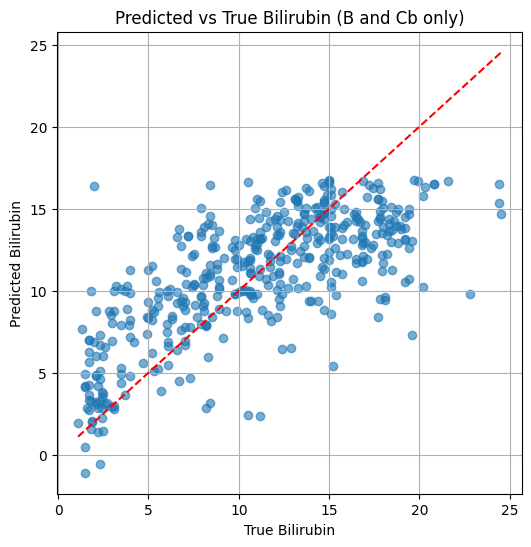

In [27]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_val).flatten()

plt.figure(figsize=(6, 6))
plt.scatter(y_val, y_pred, alpha=0.6)
plt.xlabel("True Bilirubin")
plt.ylabel("Predicted Bilirubin")
plt.title("Predicted vs True Bilirubin (B and Cb only)")
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')  # y=x line
plt.grid(True)
plt.show()


In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Step 3: Predict on the test set
y_pred = model.predict(X_test)

# Step 4: Evaluate the model
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R² score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

R² score: 0.4340
Root Mean Squared Error (RMSE): 4.0763
